In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

In [8]:
threshold = np.linspace(0,1,21)

In [9]:
from sklearn.metrics import accuracy_score
scores = []
for t in threshold:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f'% (t,score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


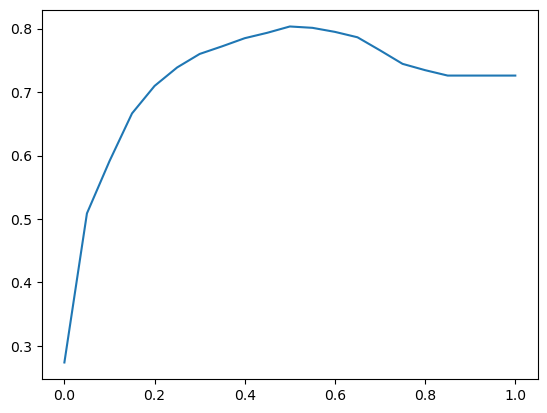

In [10]:
plt.plot(threshold, scores)

In [11]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [12]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [13]:
predict_positive

array([False, False, False, ..., False,  True,  True])

In [14]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [15]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [16]:
confusion_matrix = np.array([
    [tn, fp],
    [fn,tp]
])

In [17]:
confusion_matrix

array([[922, 101],
       [176, 210]])

In [18]:
from sklearn.metrics import roc_curve

In [19]:
fpr, tpr, threshold = roc_curve(y_val, y_pred)

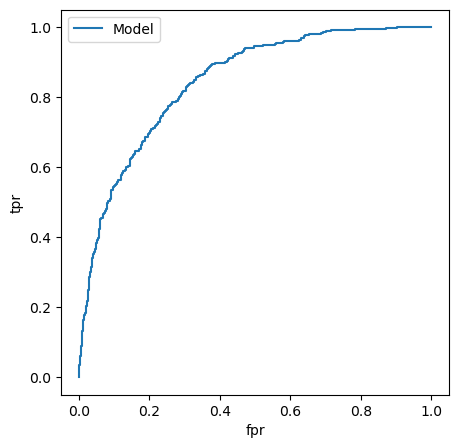

In [20]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='Model')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

In [37]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [54]:
auc(fpr,tpr)

0.843850505725819

In [22]:
def train(df,y):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    dv=DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    return dv, model

In [23]:
dv, model = train(df_train, y_train)

In [24]:
def predict(df, dv, model):
    dicts = df_train[categorical + numerical].to_dict(orient = 'records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [26]:
predict(df_val, dv, model)

array([0.09547771, 0.67932368, 0.63367473, ..., 0.53161942, 0.04254357,
       0.69872404])

In [27]:
from sklearn.model_selection import KFold

In [28]:
kfold = KFold(n_splits=10, shuffle=True, random_state = 1)

In [36]:
!pip install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.4 MB/s eta 0:00:00


In [38]:
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

ValueError: Found input variables with inconsistent numbers of samples: [564, 5070]